### Install the below modules as needed

In [1]:
#pip install keras

In [2]:
#pip install scikit-learn

In [3]:
#pip install matplotlib

In [4]:
#pip install tensorflow

In [5]:
#pip install pathlib

In [6]:
#pip install PIL

In [ ]:
#pip install pandas

## Adapted from https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [1]:
# for loading/processing the images  
#from keras.preprocessing.image import load_img    ##depreciated
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import pathlib
import PIL
import pandas as pd

### For exploratory subset of images

In [2]:
path = "../images" 
os.chdir(path)

# this list holds all the image filename
images = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the flowers list
            images.append(file.name)

len(images)

11302

In [3]:
# load the image as a 224x224 array
img = load_img(images[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

x = preprocess_input(reshaped_img)

(224, 224, 3)
(1, 224, 224, 3)


In [15]:
# load model
model16 = VGG16()
# remove the output layer
model16 = Model(inputs=model16.inputs, outputs=model16.layers[-2].output)

In [16]:
# load model
model19 = VGG19()
# remove the output layer
model19 = Model(inputs=model19.inputs, outputs=model19.layers[-2].output)

In [17]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
#VGG16 takes about 2 hours to run, VGG19 about 90 mintues. Downloaded the features achieved and will Load these from a csv instead to save time
data = {}

# lop through each image in the dataset
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model16) ### CHANGE MODEL HERE AS NEEDED
        data[image] = feat

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

### Below cell can be used for saving/loading from saved the results from the VGG model so they can be accessed without re-running the model. Uncomment out if requried

In [3]:
#Use this to save the features and filenames. Replace with desired path to files

# pd.DataFrame(feat).to_csv(PATH TO SAVE FEATURES)
# pd.DataFrame(filenames).to_csv(PATH TO SAVE FILENAMES)

#Use this to load saved features and filenames for use with the PCA + KMeans clustering. Replace with path to files

#feat = pd.read_csv(FEATURE PATH).to_numpy()
#filenames = pd.read_csv(FILENAMES PATH).to_numpy()

# feat = feat.iloc[:,-4096:].to_numpy()
# filenames=filenames.iloc[:,-1].to_numpy()

In [10]:
feat.shape

(11302, 4096)

In [11]:
filenames.shape

(11302,)

In [4]:
#Apply PCA to reduce feature space
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [5]:
x.shape

(11302, 100)

In [24]:
type(x)

numpy.ndarray

In [7]:
#kmeans clustering

kmeans = KMeans(n_init = 'auto',n_clusters=40, random_state=22)
kmeans.fit(x)

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

#

In [8]:
len(groups)

40

In [12]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        #print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_22988\3654916159.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (25,25));


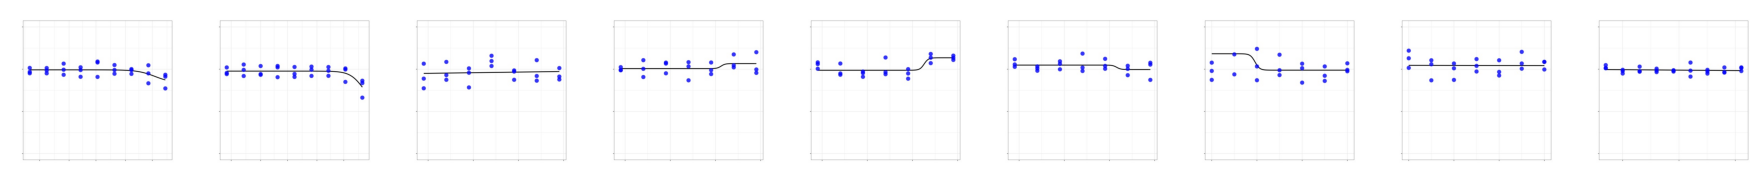

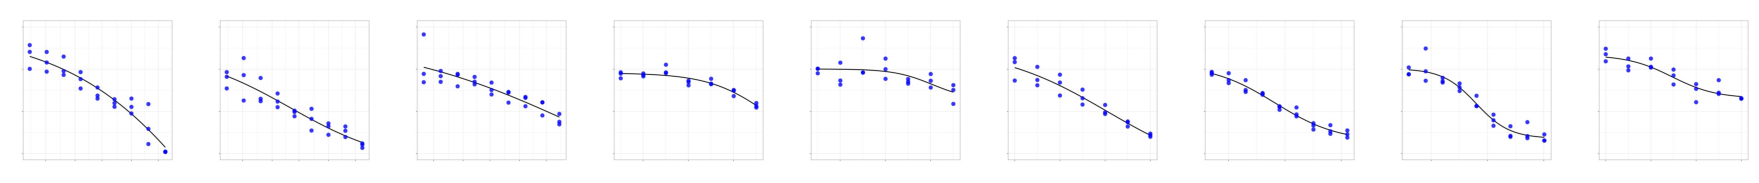

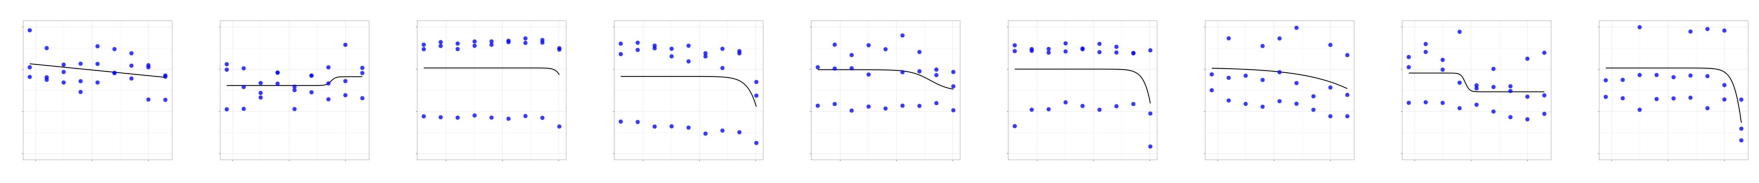

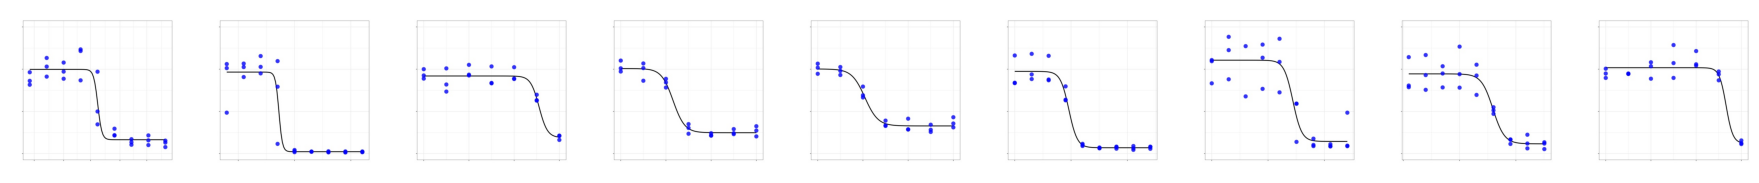

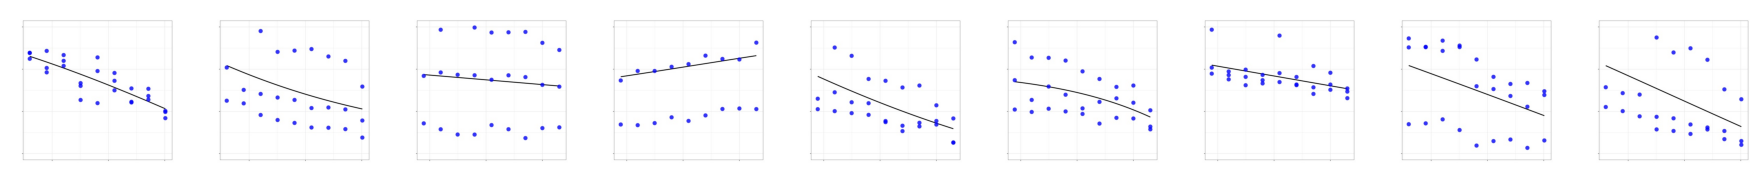

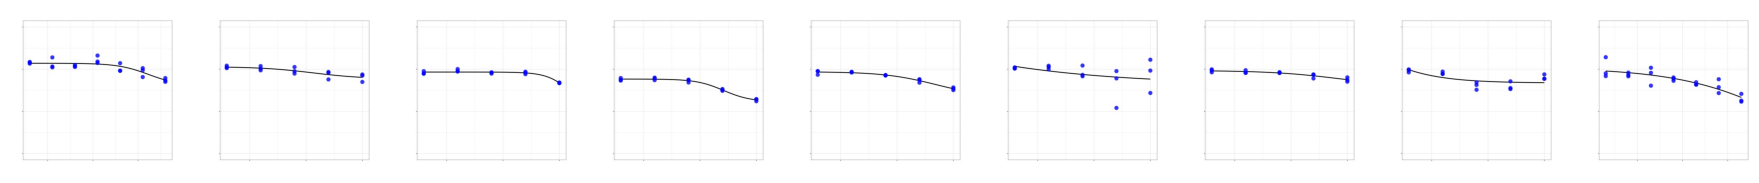

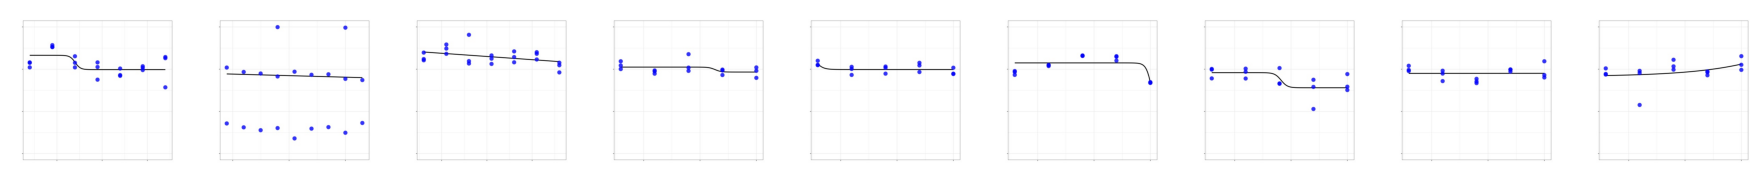

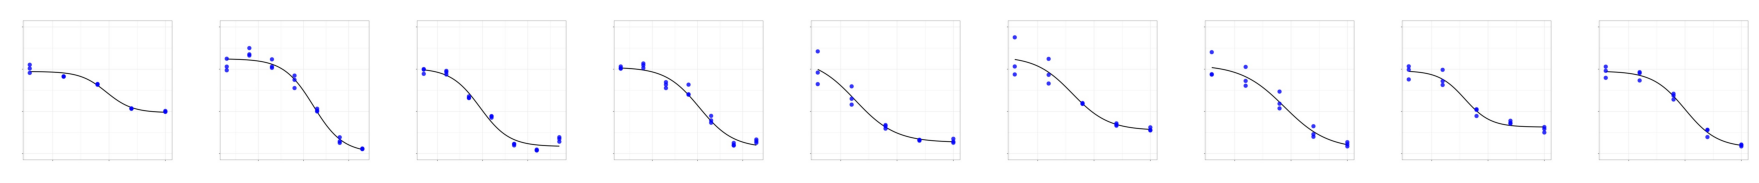

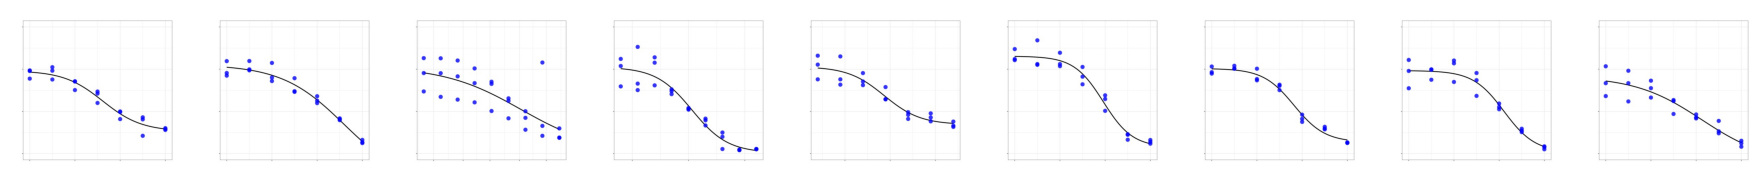

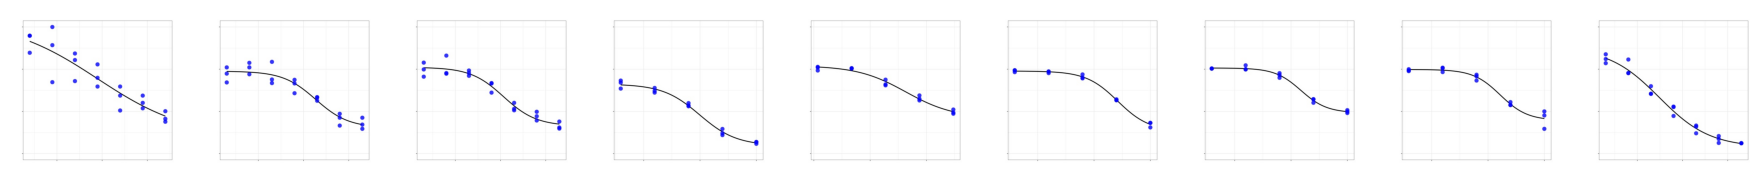

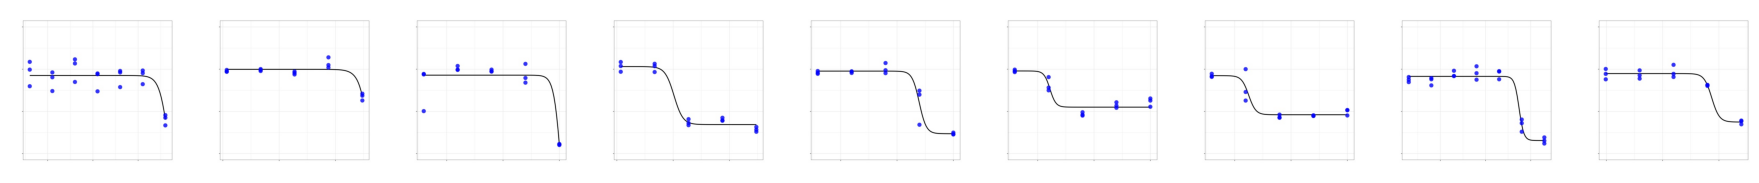

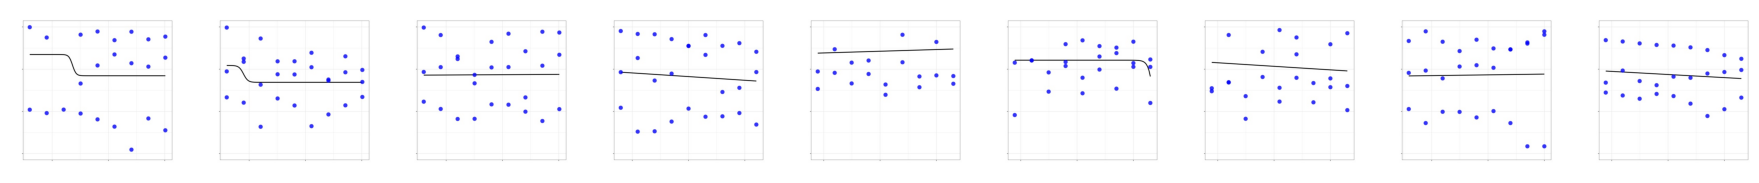

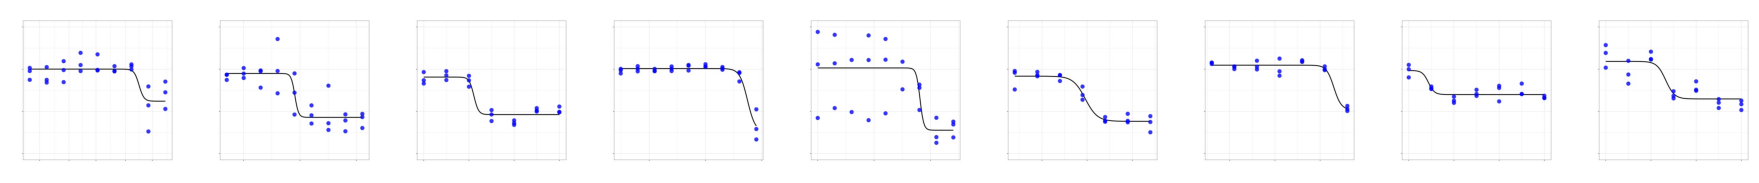

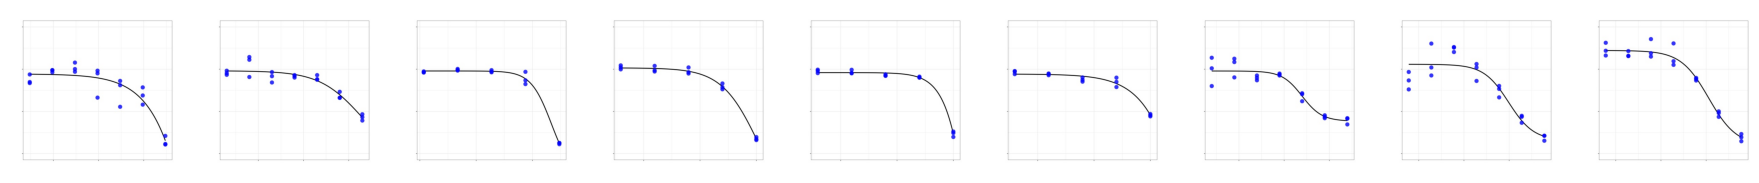

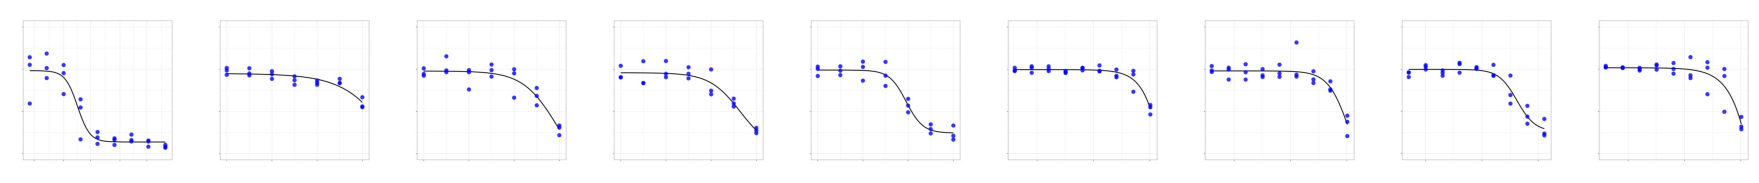

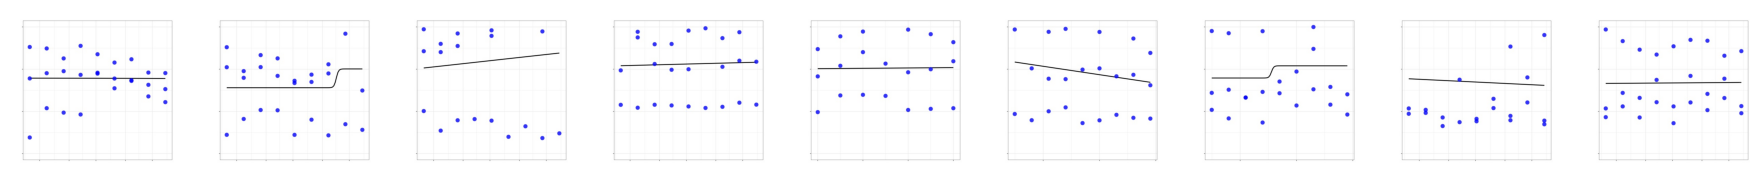

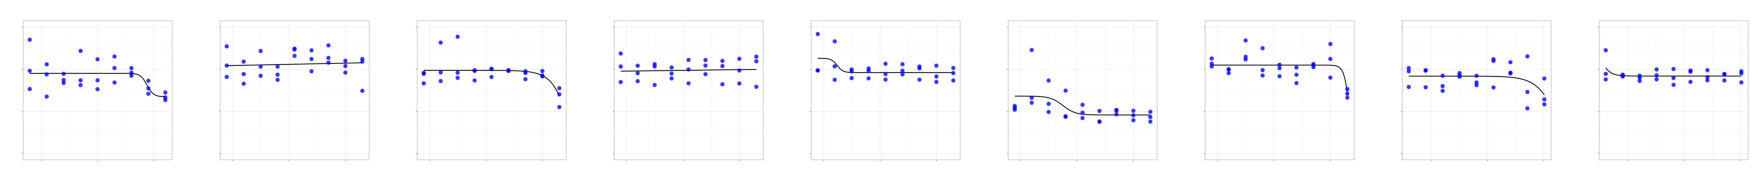

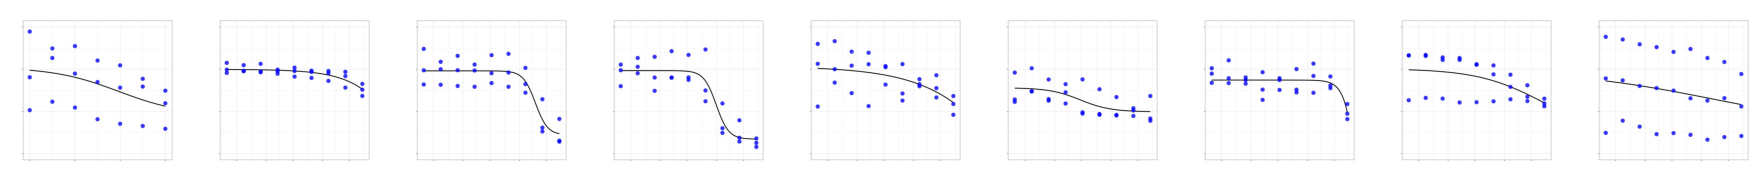

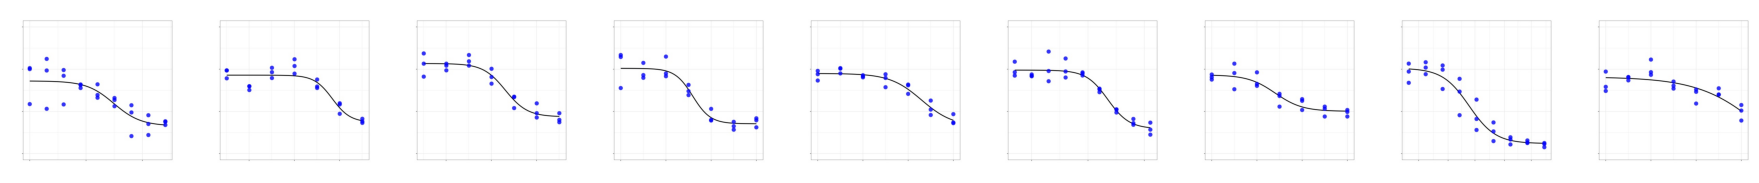

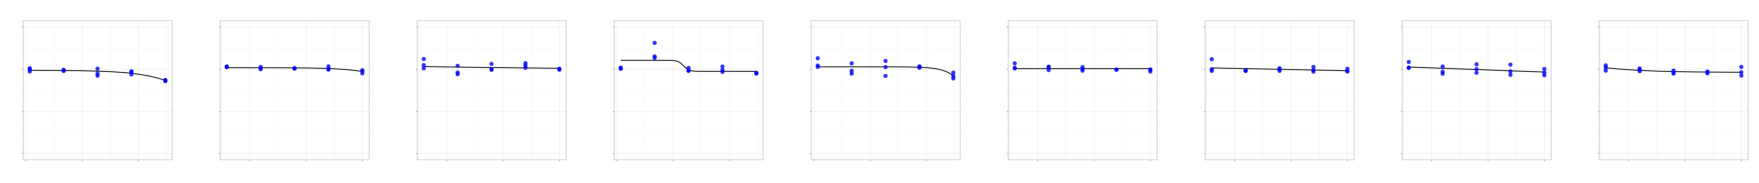

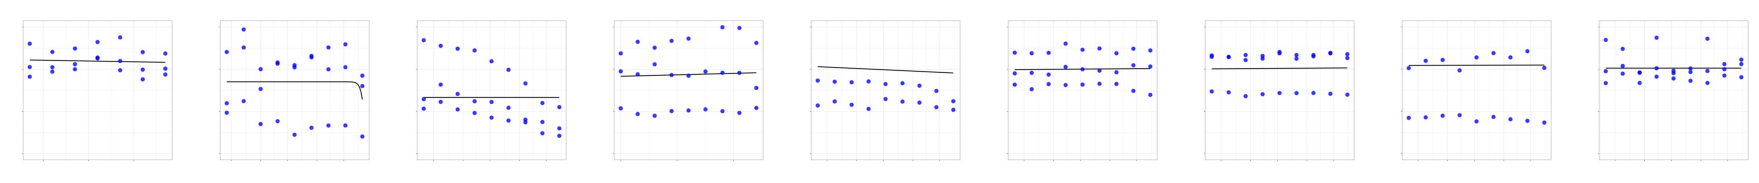

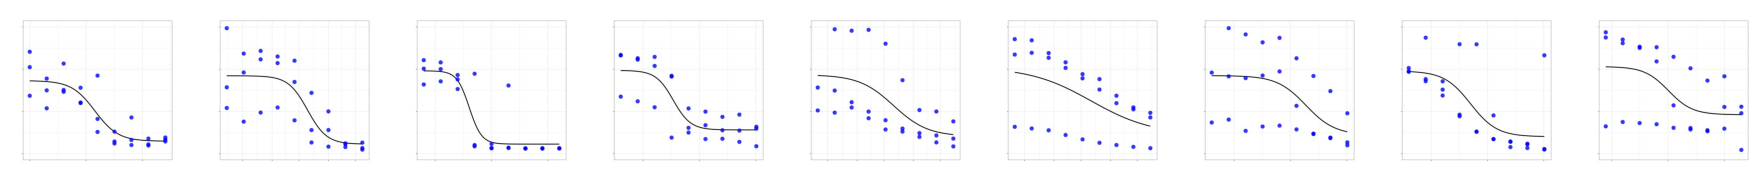

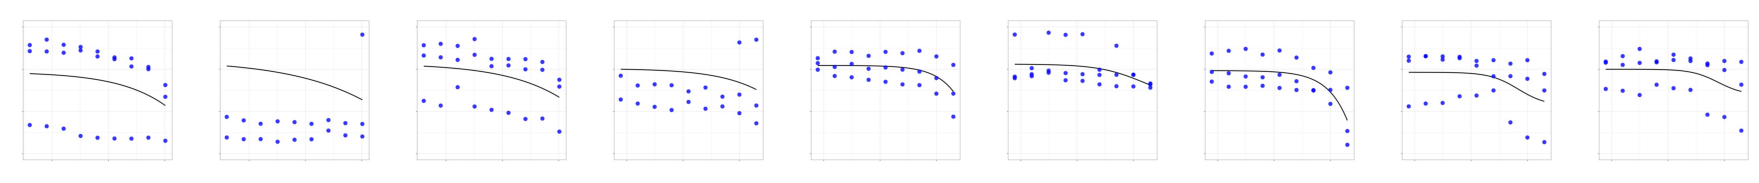

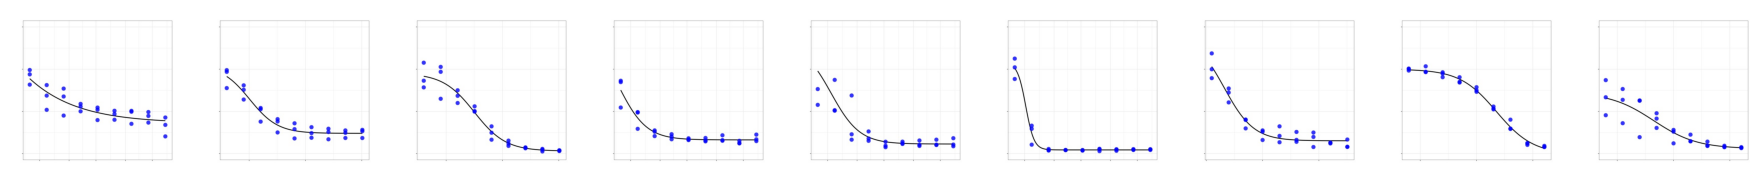

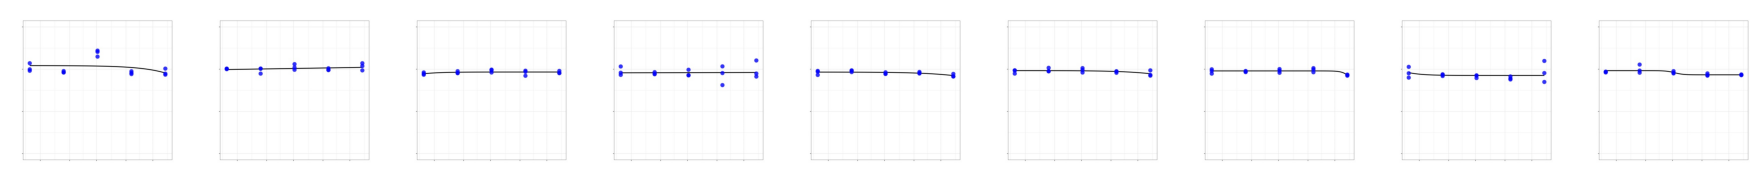

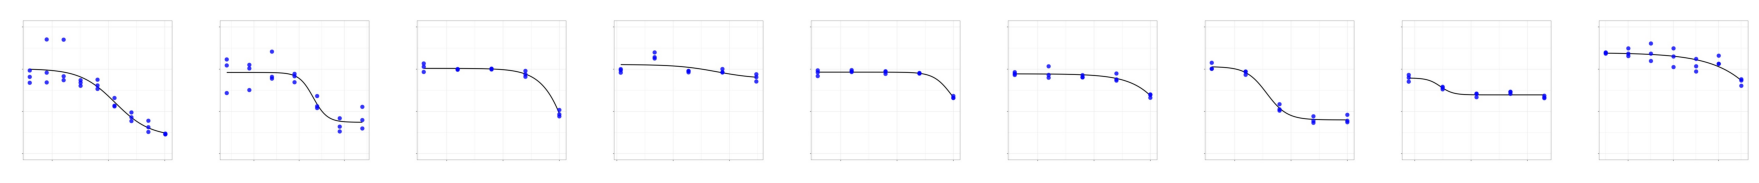

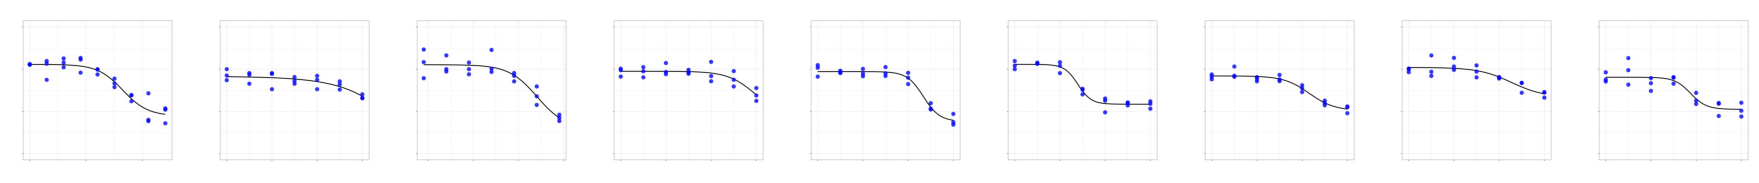

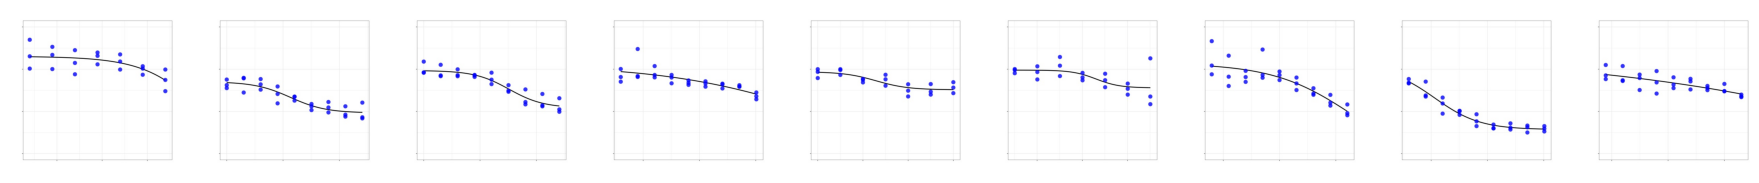

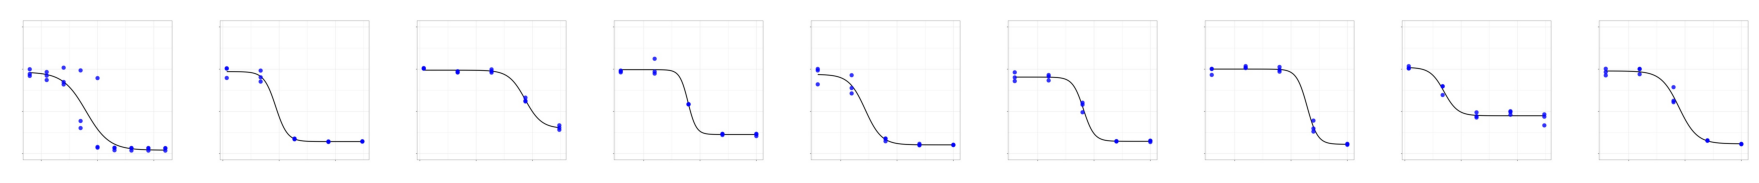

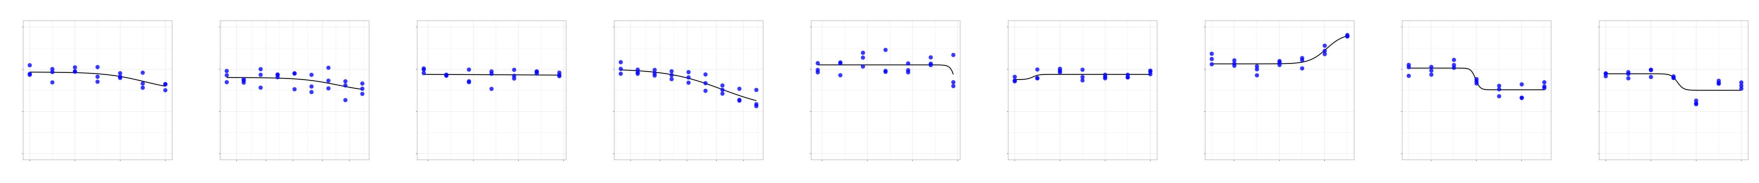

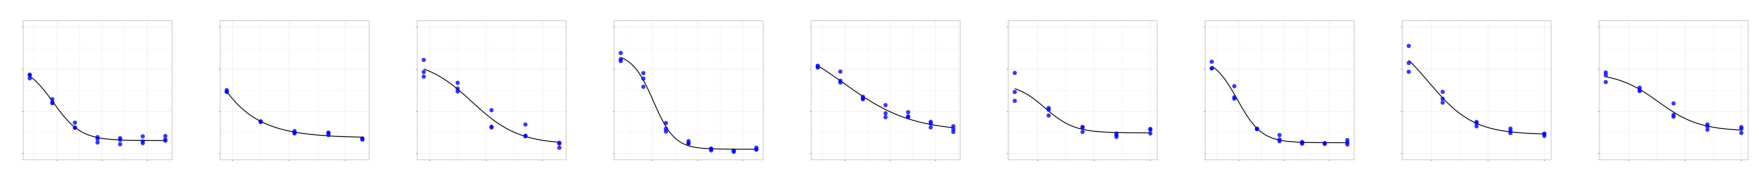

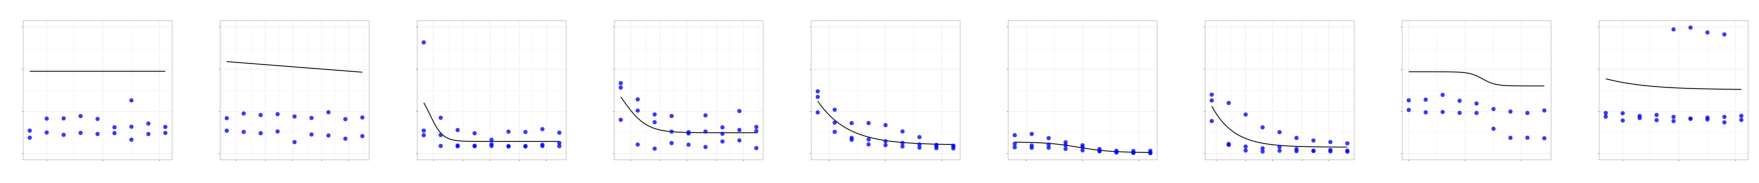

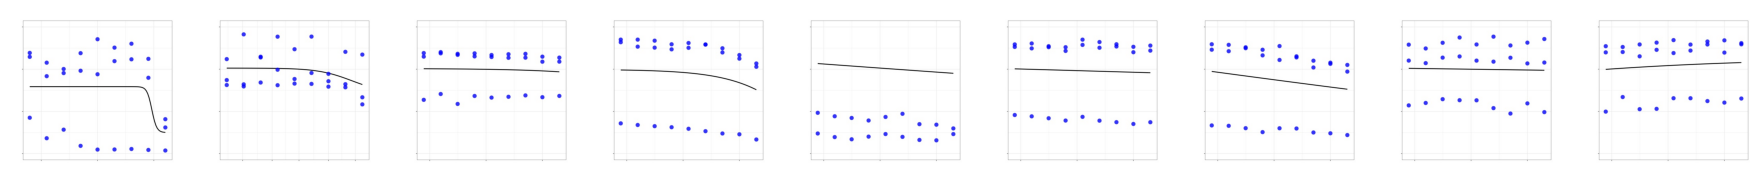

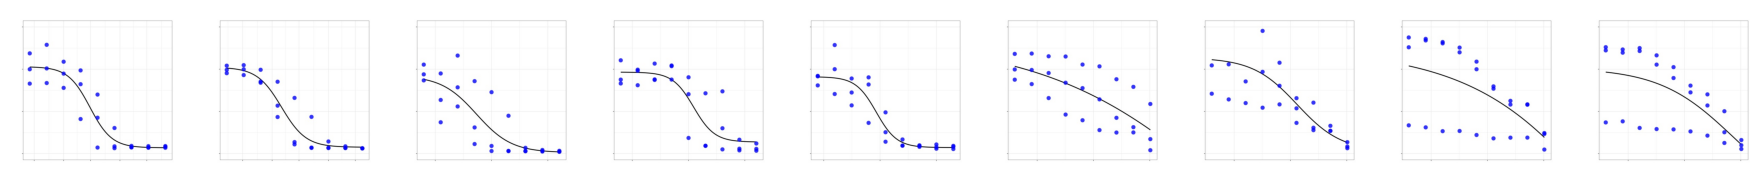

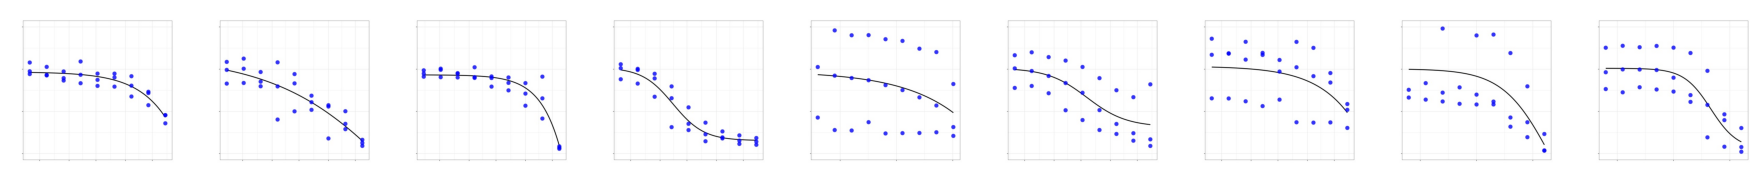

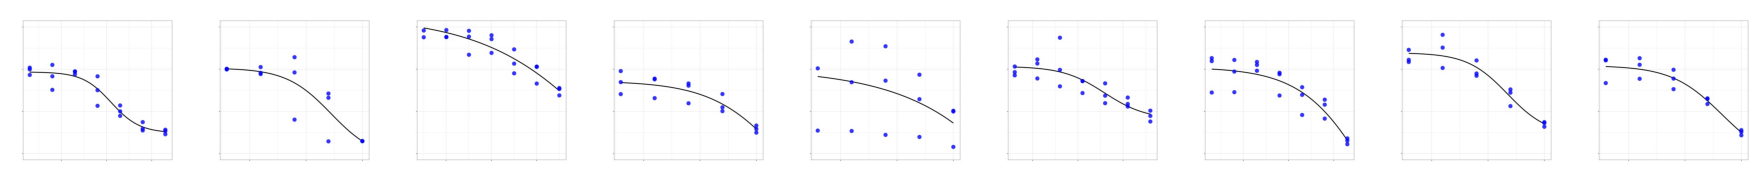

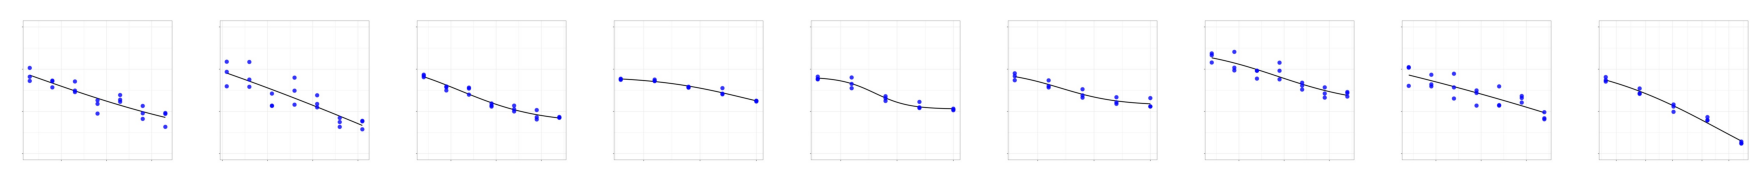

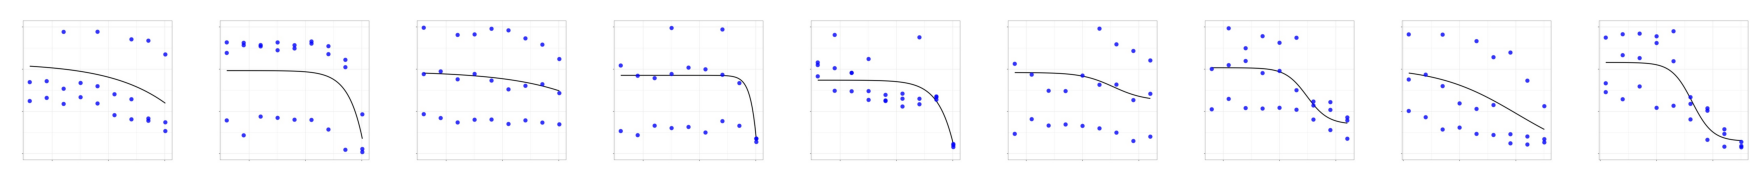

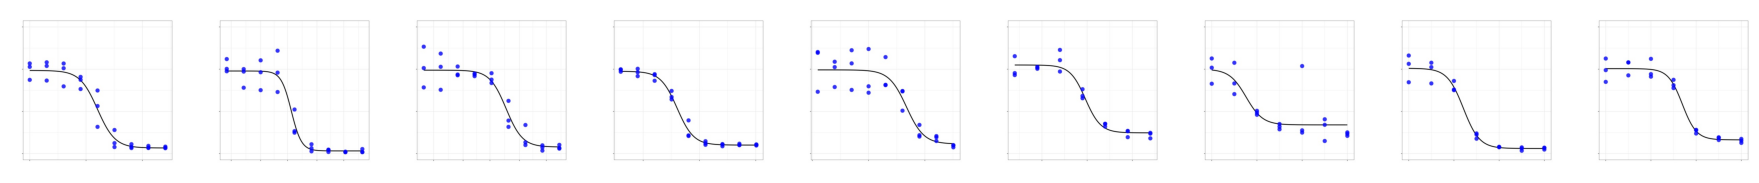

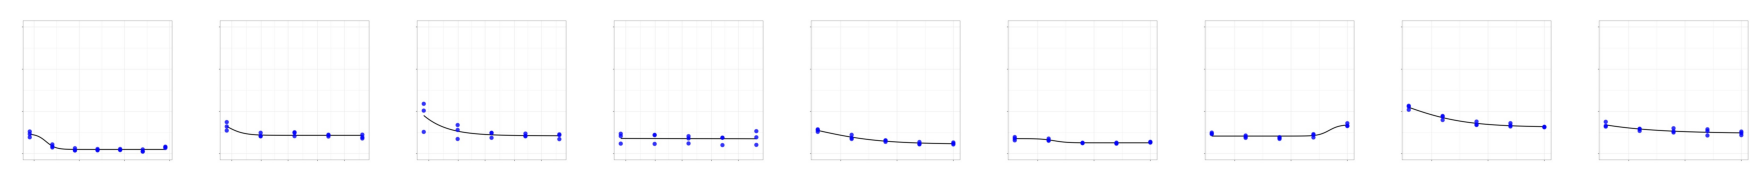

In [13]:
for cluster in range(len(groups)):
    #print("CLUSTER ",cluster)
    view_cluster(cluster)

## Manually assigning labels to the clusters and then creating a pandas df with a label for each image to use for supervised leaarning

In [51]:
Rating_dict_vgg16_40_clusters = {
    0:'No Response',1:'Mediocre',2:'Bad',3:'Mediocre',4:'Bad',5:'Bad',6:'Mediocre',7:'Mediocre',8:'Mediocre',9:'Mediocre',10:'Mediocre',
    11:'Bad',12:'Mediocre',13:'Mediocre',14:'Bad',15:'Bad',16:'Bad',17:'Bad',18:'Mediocre',19:'Bad',20:'No Response',
    21:'Bad',22:'Bad',23:'Mediocre',24:'Bad',25:'No Response',26:'Mediocre',27:'Mediocre',28:'Good',29:'Bad',30:'Mediocre',
    31:'Bad',32:'Bad',33:'Bad',34:'Bad',35:'Mediocre',36:'Mediocre',37:'Bad',38:'Good',39:'Bad'}


In [52]:
labels_df = pd.DataFrame(filenames,kmeans.labels_).reset_index().rename(columns={'index':"Cluster #",0:"Image"})
labels_df['Label'] = labels_df['Cluster #'].map(Rating_dict_vgg16_40_clusters)
labels_df.head()

Cluster #           Image        Label
0         27     image_0.jpg     Mediocre
1          6     image_1.jpg     Mediocre
2         20    image_10.jpg  No Response
3         17   image_100.jpg          Bad
4         29  image_1000.jpg          Bad

In [53]:
Good_groups = list(set(labels_df.loc[labels_df.Label=="Good","Cluster #"].to_list()))
Bad_groups = list(set(labels_df.loc[labels_df.Label=="Bad","Cluster #"].to_list()))
Mediocre_groups = list(set(labels_df.loc[labels_df.Label=="Mediocre","Cluster #"].to_list()))
No_response_groups = list(set(labels_df.loc[labels_df.Label=="No Response","Cluster #"].to_list()))
Group_list_by_label = [Good_groups,Bad_groups,Mediocre_groups,No_response_groups]
Group_list_by_label

[[28, 38],
 [2, 4, 5, 11, 14, 15, 16, 17, 19, 21, 22, 24, 29, 31, 32, 33, 34, 37, 39],
 [1, 3, 36, 35, 6, 7, 8, 9, 10, 12, 13, 18, 23, 26, 27, 30],
 [0, 25, 20]]

In [16]:
labels_dict = dict(zip(labels_df.Image,labels_df.Label))
labels_dict

{'image_0.jpg': 'Mediocre',
 'image_1.jpg': 'Bad',
 'image_10.jpg': 'Bad',
 'image_100.jpg': 'Bad',
 'image_1000.jpg': 'Bad',
 'image_10000.jpg': 'Bad',
 'image_10001.jpg': 'Bad',
 'image_10002.jpg': 'Bad',
 'image_10003.jpg': 'Mediocre',
 'image_10004.jpg': 'Good',
 'image_10005.jpg': 'Bad',
 'image_10006.jpg': 'Mediocre',
 'image_10007.jpg': 'Mediocre',
 'image_10008.jpg': 'Mediocre',
 'image_10009.jpg': 'Mediocre',
 'image_1001.jpg': 'Mediocre',
 'image_10010.jpg': 'Bad',
 'image_10011.jpg': 'Bad',
 'image_10012.jpg': 'Bad',
 'image_10013.jpg': 'Bad',
 'image_10014.jpg': 'Bad',
 'image_10015.jpg': 'Good',
 'image_10016.jpg': 'Bad',
 'image_10017.jpg': 'Bad',
 'image_10018.jpg': 'Bad',
 'image_10019.jpg': 'Mediocre',
 'image_1002.jpg': 'Bad',
 'image_10020.jpg': 'Bad',
 'image_10021.jpg': 'Mediocre',
 'image_10022.jpg': 'Bad',
 'image_10023.jpg': 'Bad',
 'image_10024.jpg': 'Bad',
 'image_10025.jpg': 'Mediocre',
 'image_10026.jpg': 'Bad',
 'image_10027.jpg': 'Mediocre',
 'image_10028.

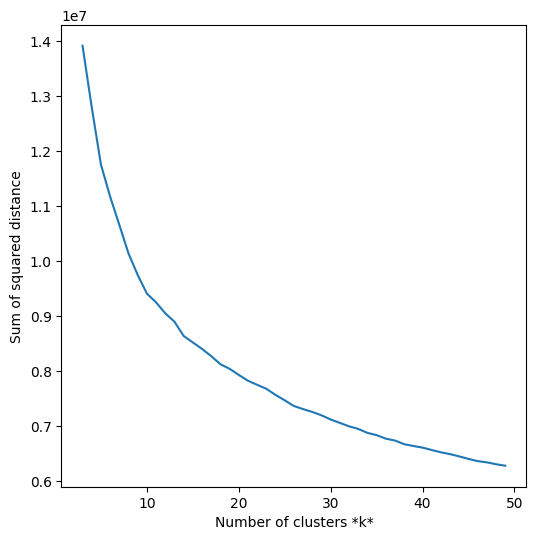

In [ ]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_init = 'auto', n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [2]:
import matplotlib.colors as mcolors
colour_names = mcolors.CSS4_COLORS
type(colour_names)
len(colour_names.keys())

148

In [3]:
colour_df = pd.DataFrame(colour_names.keys())
colour_df.head()

0
0     aliceblue
1  antiquewhite
2          aqua
3    aquamarine
4         azure

In [4]:
import random
randomlist = random.sample(range(1,148),40)
randomlist

[53,
 35,
 62,
 15,
 98,
 110,
 4,
 81,
 44,
 34,
 103,
 133,
 121,
 137,
 42,
 52,
 49,
 141,
 142,
 79,
 143,
 100,
 124,
 74,
 83,
 1,
 128,
 134,
 17,
 122,
 116,
 67,
 117,
 82,
 78,
 59,
 106,
 31,
 30,
 57]

In [5]:
colour_list = []
for i in randomlist:
    colour_list.append(colour_df.iloc[i,0])
colour_list

['gray',
 'darkslateblue',
 'khaki',
 'chocolate',
 'mistyrose',
 'paleturquoise',
 'azure',
 'lightyellow',
 'dodgerblue',
 'darkseagreen',
 'olive',
 'slategrey',
 'rosybrown',
 'tan',
 'dimgray',
 'goldenrod',
 'gainsboro',
 'turquoise',
 'violet',
 'lightslategrey',
 'wheat',
 'navajowhite',
 'salmon',
 'lightpink',
 'limegreen',
 'antiquewhite',
 'sienna',
 'snow',
 'cornflowerblue',
 'royalblue',
 'plum',
 'lightblue',
 'powderblue',
 'lime',
 'lightslategray',
 'indianred',
 'orangered',
 'darkorchid',
 'darkorange',
 'honeydew']

In [6]:
colours_chosen = ['lightgray',
 'darkslateblue',
 'palevioletred',
 'greenyellow',
 'beige',
 'silver',
 'magenta',
 'blueviolet',
 'seagreen',
 'darkseagreen',
 'goldenrod',
 'salmon',
 'chocolate',
 'navajowhite',
 'maroon',
 'mintcream',
 'darkorange',
 'crimson',
 'mediumblue',
 'deeppink',
 'lime',
 'yellowgreen',
 'mediumturquoise',
 'cyan',
 'lightgrey',
 'peru',
 'orange',
 'plum',
 'pink',
 'deepskyblue',
 'gold',
 'tomato',
 'mistyrose',
 'cadetblue',
 'lightslategrey',
 'white',
 'red',
 'steelblue',
 'thistle',
 'orangered']

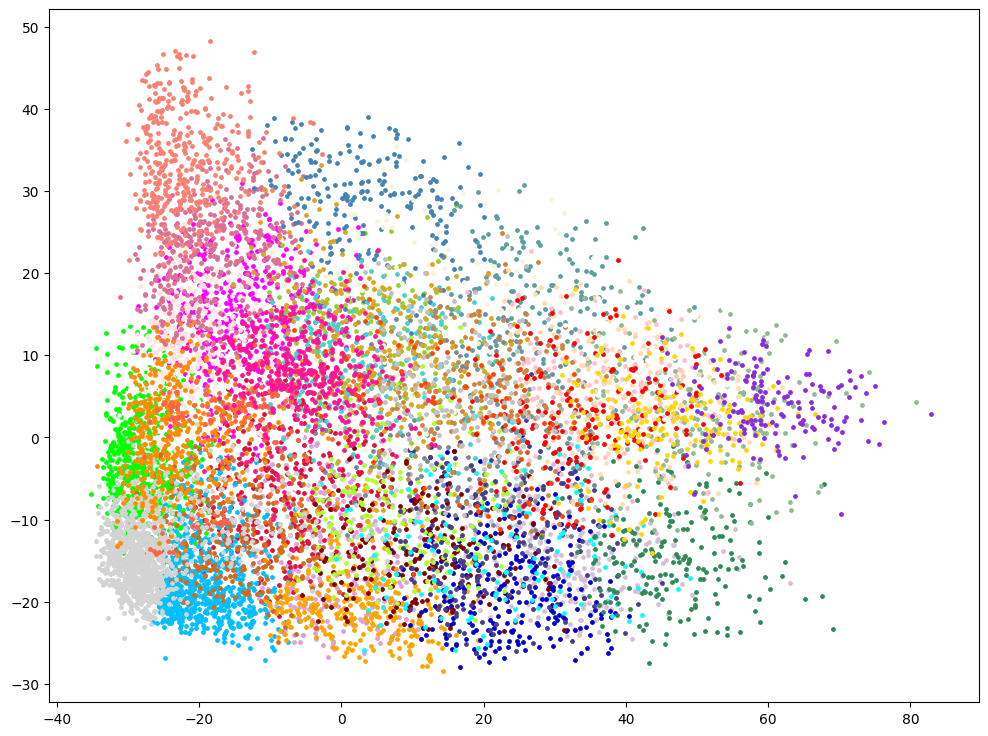

In [15]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
len(centroids)
clusters = kmeans.labels_
len(clusters)


#colour_map = plt.get_cmap('gist_rainbow')
plt.figure(figsize=(12,9))
for i in groups.keys():
    filtered_label = x[clusters == i]
    plt.scatter(filtered_label[:,0] , filtered_label[:,1],s=6, label = i, color = colours_chosen[i])#, color = [colour_map(1.*j/40) for j in range(40)])
#plt.legend()
plt.show()   

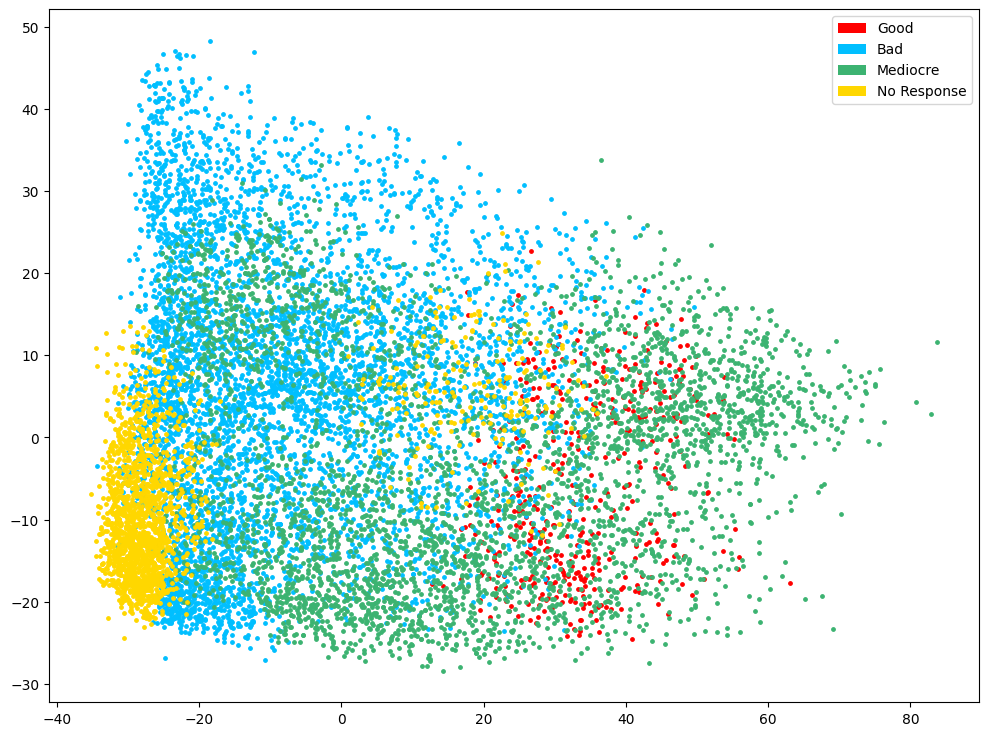

In [76]:
from matplotlib.patches import Patch

mini_colours = ["red","deepskyblue","mediumseagreen","gold"]
label_name_list = ["Good","Bad","Mediocre","No Response"]
plt.figure(figsize=(12,9))
for label_group in range(0,4):
    #plt.set_label(label_name_list[label_group])
    for i in Group_list_by_label[label_group]:
        filtered_label = x[clusters == i]
        plt.scatter(filtered_label[:,0] , filtered_label[:,1],s=6, color =mini_colours[label_group])#, color = [colour_map(1.*j/40) for j in range(40)])

legend_elements = [Patch(facecolor = 'red',label = "Good"),
                   Patch(facecolor = 'deepskyblue',label = "Bad"),
                   Patch(facecolor = 'mediumseagreen',label = "Mediocre"),
                   Patch(facecolor = 'gold',label = "No Response")]
plt.legend(handles = legend_elements)
plt.show()   

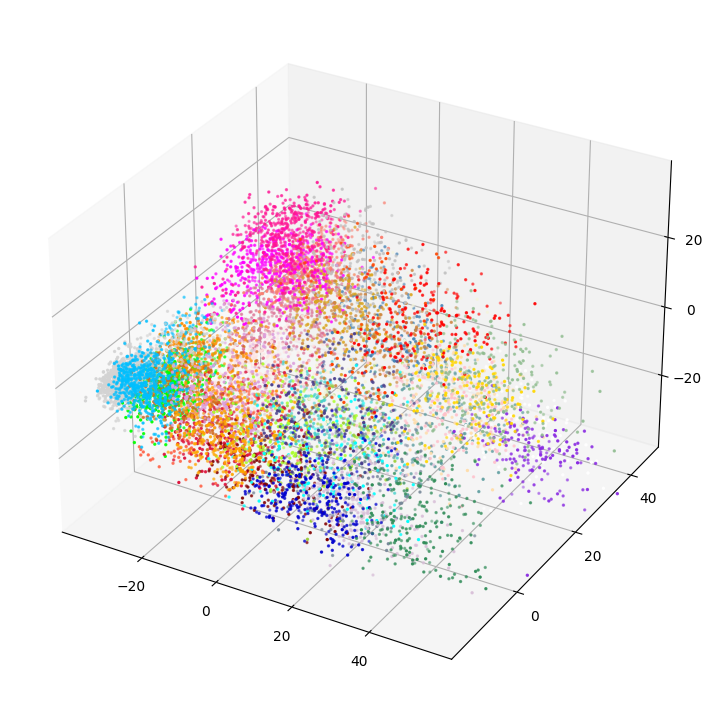

In [56]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(projection='3d')
ax.set_xticks([-40,-20,0,20,40,60])
ax.set_yticks([-20,0,20,40])
ax.set_zticks([-40,-20,0,20,40])

ax.axes.set_xlim3d(left=-39.8, right=58.8) 
ax.axes.set_ylim3d(bottom=-19.8, top=48.8) 
ax.axes.set_zlim3d(bottom=-39.8, top=39.8) 

for i in groups.keys():
    filtered_label = x[clusters == i]
    ax.scatter(filtered_label[:,0] , filtered_label[:,1], filtered_label[:,2],s=2, label = i, color = colours_chosen[i])#, color = [colour_map(1.*j/40) for j in range(40)])
#plt.legend()
plt.show()  

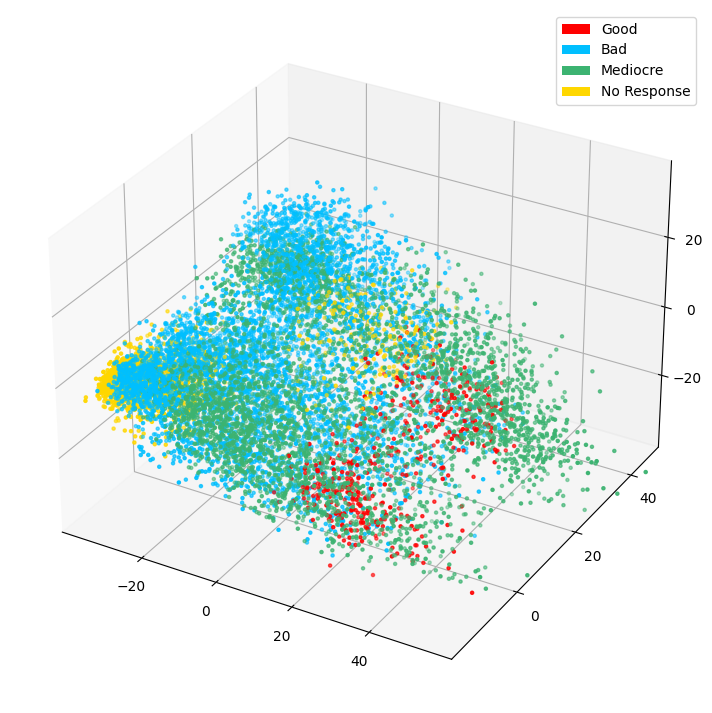

In [77]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(projection='3d')
ax.set_xticks([-40,-20,0,20,40,60])
ax.set_yticks([-20,0,20,40])
ax.set_zticks([-40,-20,0,20,40])

ax.axes.set_xlim3d(left=-39.8, right=58.8) 
ax.axes.set_ylim3d(bottom=-19.8, top=48.8) 
ax.axes.set_zlim3d(bottom=-39.8, top=39.8) 


for label_group in range(0,4):
    for i in Group_list_by_label[label_group]:
        filtered_label = x[clusters == i]
        ax.scatter(filtered_label[:,0] , filtered_label[:,1],filtered_label[:,2],s=5, label = label_group, color =mini_colours[label_group])
legend_elements = [Patch(facecolor = 'red',label = "Good"),
                   Patch(facecolor = 'deepskyblue',label = "Bad"),
                   Patch(facecolor = 'mediumseagreen',label = "Mediocre"),
                   Patch(facecolor = 'gold',label = "No Response")]
plt.legend(handles = legend_elements)
plt.show()  